In [2]:
# Install dependencies
!pip install llama-index langchain

In [11]:
!pip install llama-index-embeddings-huggingface


In [6]:
# Import libraries
import os, json, random
from llama_index.core import SimpleDirectoryReader, GPTVectorStoreIndex, ServiceContext

In [12]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


In [13]:
# Load Environment (SMOLAGENTS-like small grid)
with open("/content/drive/MyDrive/agentic_ai_demo/config/grid.json", "r") as f:
    grid_config = json.load(f)

grid = grid_config["grid"]
legend = grid_config["legend"]

print("Environment Grid:")
for row in grid:
    print(row)

# Agent starting position
agent_pos = [0, 0]  # S

Environment Grid:
['S', '', '', 'O', '']
['', 'O', '', '', '']
['', '', '', 'O', 'T']
['', '', '', '', '']
['', '', 'O', '', '']


In [14]:
# Load Knowledge Base (LLAMAINDEX) using BaseEmbedding
kb_folder = "/content/drive/MyDrive/agentic_ai_demo/knowledge_docs"
documents = SimpleDirectoryReader(kb_folder).load_data()

# 2. Configure Local CPU Embedding (Replaces BaseEmbedding)
# Using a small, efficient model like BAAI/bge-small-en-v1.5
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", device="cpu")

# 3. Build Index (No need for ServiceContext)
index = VectorStoreIndex.from_documents(documents)
print("Knowledge index built successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Knowledge index built successfully!


In [15]:
from llama_index.core.llms import CustomLLM, CompletionResponse, LLMMetadata
from llama_index.core.llms.callbacks import llm_completion_callback
from typing import Any

In [17]:
# Define LlamaIndex-compatible local LLM
class LocalLLM(CustomLLM):
    context_window: int = 3900
    num_output: int = 256
    model_name: str = "custom_rule_based"

    @property
    def metadata(self) -> LLMMetadata:
        return LLMMetadata(
            context_window=self.context_window,
            num_output=self.num_output,
            model_name=self.model_name,
        )

    @llm_completion_callback()
    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        prompt_lower = prompt.lower()
        if "obstacle" in prompt_lower:
            text = "Try moving around the obstacle."
        elif "target" in prompt_lower:
            text = "Move towards the target."
        else:
            text = "Plan your next move."
        return CompletionResponse(text=text)

    @llm_completion_callback()
    def stream_complete(self, prompt: str, **kwargs: Any):
        raise NotImplementedError("Streaming not supported in this demo.")

# Initialize the custom LLM and attach to Settings
Settings.llm = LocalLLM()
query_engine = index.as_query_engine()

In [18]:
# LANGGRAPH-style reasoning flow
def agent_decision():
    x, y = agent_pos
    cell = grid[x][y]

    # Map cell types to natural language queries for the RAG engine
    query_map = {"O": "obstacle ahead", "T": "target reached", ".": "what to do next"}

    # Use the actual RAG query engine
    response = query_engine.query(query_map.get(cell, "status report"))

    print(f"Agent at {agent_pos} sees '{cell}' -> {response}")
    return response

In [19]:
# Optional MCP / A2A placeholders
def multi_step_plan():
    print("Planning multi-step actions...")

def agent_to_agent_comm():
    print("Simulating agent-to-agent communication...")


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [22]:
# Visualization Setup
def setup_plot():
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(figsize=(5, 5))
    return fig, ax

def update_visualization(ax, pos, grid):
    ax.clear()
    rows, cols = len(grid), len(grid[0])

    # Draw Grid Elements
    for r in range(rows):
        for c in range(cols):
            cell = grid[r][c]
            color = 'white'
            if cell == 'O': color = 'black'  # Obstacle
            if cell == 'T': color = 'gold'   # Target

            rect = plt.Rectangle((c, rows - 1 - r), 1, 1, facecolor=color, edgecolor='gray')
            ax.add_patch(rect)

    # Draw Agent
    agent_circle = plt.Circle((pos[1] + 0.5, rows - 1 - pos[0] + 0.5), 0.3, color='blue', label='Agent')
    ax.add_patch(agent_circle)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(range(cols + 1))
    ax.set_yticks(range(rows + 1))
    ax.set_aspect('equal')
    ax.set_title(f"Agent Step - Pos: {pos}")
    plt.draw()
    plt.pause(0.5)  # Brief pause to see the movement

Agent at [2, 4] sees 'T' -> Move towards the target.


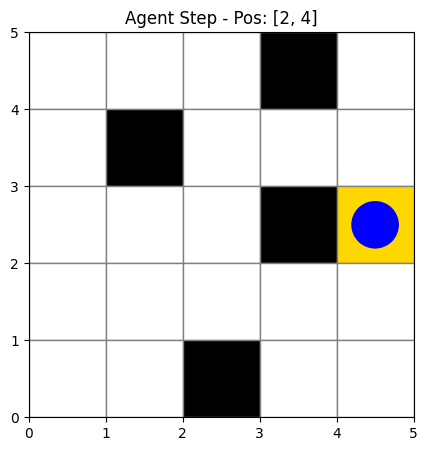

Agent at [1, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

Agent at [0, 4] sees '' -> Move towards the target.


<Figure size 640x480 with 0 Axes>

In [39]:
# Run simple demo
# Assumes grid and agent_pos are defined from your previous cell
fig, ax = setup_plot()

for step in range(10):
    # Reasoning & Decision (from previous steps)
    action_text = agent_decision()

    # Visualize current state
    update_visualization(ax, agent_pos, grid)

    # Simulation Logic: Simple pathing towards Target (0,4)
    if agent_pos[0] > 0: agent_pos[0] -= 1
    if agent_pos[1] < 4: agent_pos[1] += 1

    if grid[agent_pos[0]][agent_pos[1]] == 'T':
        update_visualization(ax, agent_pos, grid)
        print("Target Reached!")
        break

plt.ioff() # Turn off interactive mode
plt.show()